In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import normal
import matplotlib.pyplot as plt
from utils import *
from rule import *
from evaluation import *
from IPython.display import clear_output
import time
import random

from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

params = {
    "n_layers" : 3,
    "layer_width" : 3,
    
    "cell_state_size" : 5,
    
    "inputs" : 2,
    "outputs" : 1,
    
    "n_samples_per_evaluation" : 30, 
    "time_per_sample" : 10,    
    "population_size" : 20,
    
    "mutation_rate" : 0.05,
    
    "n_cell_hyperparams" : 1,
    "output_cell_coord" : [2,3],
}

cell_hyperparams = torch.zeros([params["layer_width"]+2, params["n_layers"]+2, params["n_cell_hyperparams"]])
cell_hyperparams[params["output_cell_coord"][0]][params["output_cell_coord"][1]][0] = 1
cell_hyperparams[1][1][0] = -1
cell_hyperparams[2][1][0] = -1

params["cell_hyperparams"] = cell_hyperparams


In [2]:
rules = []
for i in range(params["population_size"]):
    rules.append(Rule(params))

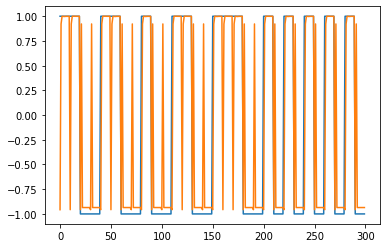

125 | Best Rewards : -2   

KeyboardInterrupt: 

In [3]:
params["verbose"] = False

gen = gate_sample_gen(gate="XOR")

for e in range(2000):
    rules, best = evaluate_population(rules, gen, params)
    
    if e % 30 == 0:
        clear_output(wait=True)
        plt.plot(best['best_history']['label_history'])
        plt.plot(best['best_history']['predicted_history'])
        
        plt.show()
    print(f"\r{e} | Best Rewards : {best['best_reward']}   ", end="")
    
    
    
    
    #print(len(new_rules))
    

In [ ]:
#print(best['best_history']['label_history'])]
plt.plot(best['best_history']['label_history'])
plt.plot(best['best_history']['predicted_history'])

In [ ]:
best_rule =  best["best_rule"]
best_rule.params = params
params["time_per_sample"] = 30
params["verbose"] = True
rewards, history = evaluate_rule_on_generator(best_rule, gen, params)

In [ ]:
plt.plot(history['label_history'])
plt.plot(history['predicted_history'])

In [ ]:
pretty_print(best_rule.build_grid())

In [ ]:
x = best_rule.build_grid()
x = insert_io(x, torch.tensor([-1,1]), torch.tensor([1]))
pretty_print(x)

In [6]:
best_rule = best["best_rule"]
x = best_rule.build_grid()

In [10]:
#inputs = [[-1,-1], [-1,1], [1,-1], [1,1]]
#outputs=[[-1],[1],[1],[-1]]
inputs = [[-1,-1], [1,1]]
outputs=[[-1],[1]]
#inputs = [[-1,1]]
#outputs=[[1]]
for e in range(100):
    for in_,out in zip(inputs,outputs):
       # if(random.choice([True, False])):
        #    out = [0]
        for i in range(30):
            #print(in_, out)
            o = out
            #if(i < 10):
            
                
            x = insert_io(x, torch.tensor(in_), torch.tensor(o))
            
            clear_output(wait=True)
            pretty_print(x)
            
            
            x = best_rule.apply_rule(x)
            
            n_predicted = x[params["output_cell_coord"][0]][params["output_cell_coord"][1]][0]
            print(n_predicted.squeeze().detach().numpy().item())
            time.sleep(0.1)
            #x = insert_io(x, torch.tensor(in_), torch.tensor(out))
            
            
            
            #x = insert_io(x, torch.tensor(in_), torch.tensor(out))

        #pretty_print(x)
        #print(x[3][3][0])

    

[0.000 0....][0.000 0....][0.000 0....][0.000 0....][0.000 0....]
[1.000 1....][0.996 -0...][-0.981 -...][0.967 -0...][0.000 0....]
[1.000 1....][-0.988 -...][1.000 -0...][-0.955 -...][1.000 1....]
[0.000 0....][-0.983 -...][-0.946 -...][0.984 -0...][0.000 0....]
[0.000 0....][0.000 0....][0.000 0....][0.000 0....][0.000 0....]
-0.9545266032218933


KeyboardInterrupt: 

In [ ]:

in_ = [-1,1]
out = [0]
for i in range(15):
    x = insert_io(x, torch.tensor(in_), torch.tensor(out))
    x = best_rule.apply_rule(x)
    
    #x = insert_io(x, torch.tensor(in_), torch.tensor(out))
    
    print(x[3][3][0])

In [ ]:
pretty_print(x)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([0,1],[3,4])
plt.plot([0,1],[3,1])

In [ ]:
plt.plot(best['best_history']['label_history'][0:60])
plt.plot(best['best_history']['predicted_history'][0:60])

In [ ]:
params["verbose"] = True
evaluate_rule(best_rule,[-1,-1],[0], params)

In [ ]:
import importlib
importlib.reload(Rule)


In [ ]:
plt.plot(history['label_history'])
plt.plot(history['predicted_history'])

In [ ]:
rewards

In [ ]:
{[2,3] : 4}